Let's import the dataset first.

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("monishakant/dataset-for-stress-analysis-in-social-media")

print("Path to dataset files:", path)

c:\Users\HopeE\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\HopeE\.cache\kagglehub\datasets\monishakant\dataset-for-stress-analysis-in-social-media\versions\1


In [5]:
import pandas as pd
import os

file_path = os.path.join(path, 'dreaddit_StressAnalysis - Sheet1.csv')

df = pd.read_csv(file_path)
df.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1514980773,22,-1.238793,...,1.0000,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1493348050,5,7.684583,...,1.4000,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909
2,7977,ptsd,8eeu1t,"(5, 10)",We'd be saving so much money with this new hou...,1,1.0,1524516630,10,2.360408,...,1.1429,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818
3,1214,ptsd,8d28vu,"[2, 7]","My ex used to shoot back with ""Do you want me ...",1,0.5,1524018289,5,5.997000,...,1.0000,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667
4,1965,relationships,7r1e85,"[23, 28]",I haven’t said anything to him yet because I’m...,0,0.8,1516200171,138,4.649418,...,1.1250,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667


In [122]:
df.shape

(715, 116)

<Axes: xlabel='label', ylabel='count'>

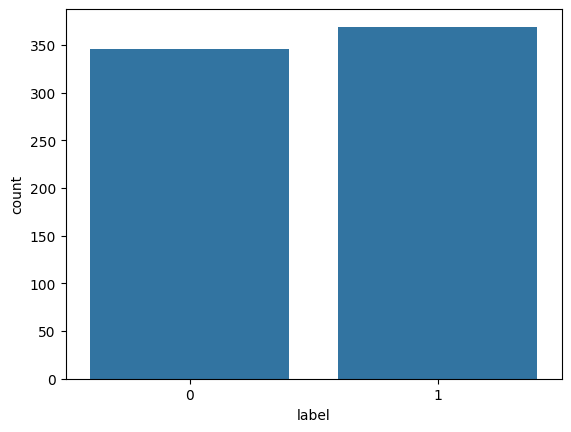

In [6]:
import seaborn as sns

sns.countplot(data=df,x="label")

Let's take a look at the data distribution across different subreddits.

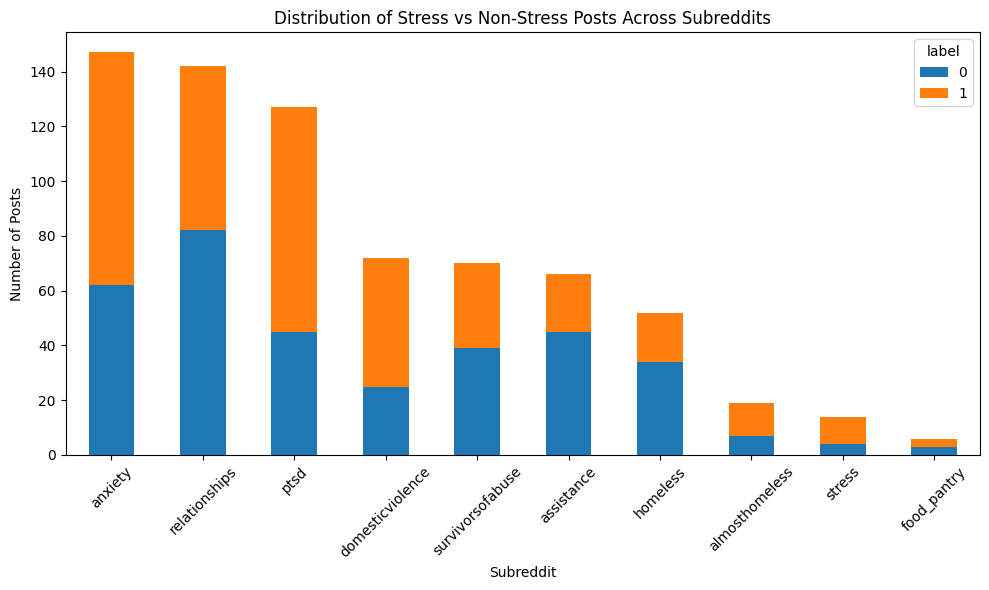

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Count posts per subreddit per label
counts = (
    df
    .groupby(['subreddit', 'label'])
    .size()
    .unstack(fill_value=0)
)

# Sort by total volume (optional but cleaner)
counts["total"] = counts.sum(axis=1)
counts = counts.sort_values("total", ascending=False)
counts = counts.drop(columns="total")

counts.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6)
)

plt.xlabel("Subreddit")
plt.ylabel("Number of Posts")
plt.title("Distribution of Stress vs Non-Stress Posts Across Subreddits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's see the variation of text length across all the samples.

<Axes: xlabel='text', ylabel='Count'>

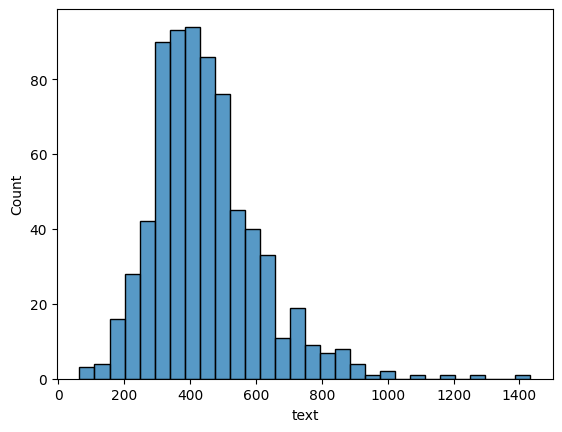

In [8]:
df_len = df["text"].str.len()
sns.histplot(df_len, bins=30)

### Model 1: Logistic Regression with TF-IDF  

Let's try out a base model first with just the text and labels using TF-IDF with logistic regression.

We first cleaned the text and remove stopwords.

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

df_1 = df[['text', 'label']]

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Lowercase, remove special characters, and extra spaces."""
    text = text.lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only alphanumeric characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords + Lemmatization
    return ' '.join(words)

df_1['cleaned_text'] = df_1['text'].apply(clean_text)

<Axes: xlabel='cleaned_text', ylabel='Count'>

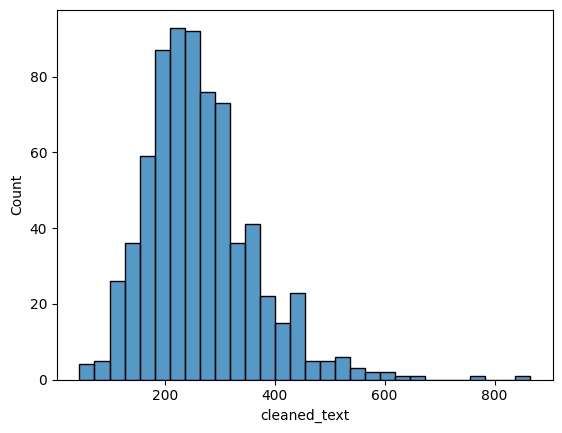

In [10]:
sns.histplot(df_1['cleaned_text'].str.len(), bins=30)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_df, val_df = train_test_split(
    df_1,
    test_size=0.2,
    stratify=df_1['label'],
    random_state=42
)

X_train = train_df['cleaned_text']
y_train = train_df['label']

X_val = val_df['cleaned_text']
y_val = val_df['label']

tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])

tfidf_lr.fit(X_train, y_train)

val_preds = tfidf_lr.predict(X_val)
val_probs = tfidf_lr.predict_proba(X_val)[:,1]

print("F1:", f1_score(y_val, val_preds))
print(classification_report(y_val, val_preds))


F1: 0.6580645161290323
              precision    recall  f1-score   support

           0       0.63      0.57      0.60        69
           1       0.63      0.69      0.66        74

    accuracy                           0.63       143
   macro avg       0.63      0.63      0.63       143
weighted avg       0.63      0.63      0.63       143



Let's dive deeper to see what are some top stress predictors and non-stress predictors.

In [12]:
import numpy as np

feature_names = tfidf_lr.named_steps["tfidf"].get_feature_names_out()
coefs = tfidf_lr.named_steps["clf"].coef_[0]

top_positive = np.argsort(coefs)[-10:]
top_negative = np.argsort(coefs)[:10]

print("Top Stress Predictors:")
print(feature_names[top_positive])

print("\n")

print("Top Non-Stress Predictors:")
print(feature_names[top_negative])

Top Stress Predictors:
['fucking' 'know' 'hard' 'anxious' 'like' 'feel' 'dont know' 'feel like'
 'anxiety' 'im']


Top Non-Stress Predictors:
['post' 'url' 'friend' 'share' 'met' 'love' 'thanks' 'pretty' 'want'
 'homeless']


### Model 1b: DistillBERT

It seems that some of the common ngrams are not indicative of the context such as "know", "like", "friend", "post". Let's try to extract more semantic meaning using DistillBERT.

We use the original text from the samples rather than the cleaned text so that negation, pronoun usage and grammer structure is restored.

In [17]:
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)

train_df_bert, val_df_bert = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

In [18]:
train_dataset = Dataset.from_pandas(train_df_bert[["text", "label"]])
val_dataset   = Dataset.from_pandas(val_df_bert[["text", "label"]])

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


Map: 100%|██████████| 143/143 [00:00<00:00, 3610.51 examples/s]


Load model and define metrics.

In [21]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

# Freeze all layers except the last two layers due to smaller dataset size and to prevent overfitting
for name, param in model.named_parameters():
    # Keep trainable: last 2 encoder layers (10, 11) + classification head (pre_classifier, classifier)
    if "encoder.layer.10" in name or "encoder.layer.11" in name or "pre_classifier" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    
    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 898.55it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Training setup.

In [22]:
training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    learning_rate=3e-5,
    weight_decay=0.01,
    load_best_model_at_end=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
c:\Users\HopeE\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Step,Training Loss


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


TrainOutput(global_step=108, training_loss=0.6765639693648727, metrics={'train_runtime': 815.8689, 'train_samples_per_second': 2.103, 'train_steps_per_second': 0.132, 'total_flos': 227314056093696.0, 'train_loss': 0.6765639693648727, 'epoch': 3.0})

Evaluate results.

In [23]:
eval_results = trainer.evaluate()
print(eval_results)

c:\Users\HopeE\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.6645255088806152, 'eval_f1': 0.7448979591836735, 'eval_precision': 0.5983606557377049, 'eval_recall': 0.9864864864864865, 'eval_runtime': 24.0748, 'eval_samples_per_second': 5.94, 'eval_steps_per_second': 0.374, 'epoch': 3.0}


### Model 2: XGBoost with LIWC Features

Let's try using some useful LIWC features to build a feature based model to highlight the important of certain features.

LIWC features could allow for more interpretable results on which aspects of the posts affect the labels more.


In [24]:
liwc_cols = [col for col in df.columns if col.startswith("lex_liwc")]

liwc_cols

['lex_liwc_WC',
 'lex_liwc_Analytic',
 'lex_liwc_Clout',
 'lex_liwc_Authentic',
 'lex_liwc_Tone',
 'lex_liwc_WPS',
 'lex_liwc_Sixltr',
 'lex_liwc_Dic',
 'lex_liwc_function',
 'lex_liwc_pronoun',
 'lex_liwc_ppron',
 'lex_liwc_i',
 'lex_liwc_we',
 'lex_liwc_you',
 'lex_liwc_shehe',
 'lex_liwc_they',
 'lex_liwc_ipron',
 'lex_liwc_article',
 'lex_liwc_prep',
 'lex_liwc_auxverb',
 'lex_liwc_adverb',
 'lex_liwc_conj',
 'lex_liwc_negate',
 'lex_liwc_verb',
 'lex_liwc_adj',
 'lex_liwc_compare',
 'lex_liwc_interrog',
 'lex_liwc_number',
 'lex_liwc_quant',
 'lex_liwc_affect',
 'lex_liwc_posemo',
 'lex_liwc_negemo',
 'lex_liwc_anx',
 'lex_liwc_anger',
 'lex_liwc_sad',
 'lex_liwc_social',
 'lex_liwc_family',
 'lex_liwc_friend',
 'lex_liwc_female',
 'lex_liwc_male',
 'lex_liwc_cogproc',
 'lex_liwc_insight',
 'lex_liwc_cause',
 'lex_liwc_discrep',
 'lex_liwc_tentat',
 'lex_liwc_certain',
 'lex_liwc_differ',
 'lex_liwc_percept',
 'lex_liwc_see',
 'lex_liwc_hear',
 'lex_liwc_feel',
 'lex_liwc_bio',
 '

Let's take a look at which features increases in stress directly from the data.

In [25]:
stress_means = df[df["label"] == 1][liwc_cols].mean()
nonstress_means = df[df["label"] == 0][liwc_cols].mean()

comparison = pd.DataFrame({
    "Stress_Mean": stress_means,
    "NonStress_Mean": nonstress_means,
    "Difference": stress_means - nonstress_means
})

comparison.sort_values("Difference", ascending=False).head(10)

,Stress_Mean,NonStress_Mean,Difference
lex_liwc_Authentic,77.099539,62.257861,14.841678
lex_liwc_WC,88.663957,82.471098,6.192858
lex_liwc_i,10.800949,7.824104,2.976844
lex_liwc_negemo,4.519539,2.124971,2.394568
lex_liwc_function,60.009756,57.697746,2.312010
lex_liwc_Dic,93.213930,91.766936,1.446993
lex_liwc_ppron,14.757751,13.419277,1.338473
lex_liwc_pronoun,20.677805,19.390202,1.287603
lex_liwc_focuspresent,12.792710,11.701040,1.091670
lex_liwc_anx,1.446829,0.483902,0.962928


The large difference for lex_liwc_Authenthic may be caused by imbalance data as that column is very left skewed, let's compute Cohen's d to get the standardized difference.

In [26]:
def cohens_d(x1, x2):
    pooled_std = np.sqrt((x1.var() + x2.var()) / 2)
    return (x1.mean() - x2.mean()) / pooled_std

effect_sizes = {}

for col in liwc_cols:
    stress_vals = df[df["label"] == 1][col]
    nonstress_vals = df[df["label"] == 0][col]
    effect_sizes[col] = cohens_d(stress_vals, nonstress_vals)

effect_df = pd.Series(effect_sizes).sort_values(ascending=False)
effect_df.head(10)

lex_liwc_negemo       0.946596
lex_liwc_i            0.708725
lex_liwc_anx          0.667917
lex_liwc_Authentic    0.479924
lex_liwc_sad          0.472382
lex_liwc_feel         0.471518
lex_liwc_anger        0.434064
lex_liwc_function     0.377482
lex_liwc_swear        0.364373
lex_liwc_conj         0.328411
dtype: float64

Building XGBoost model only using the K important LIWC features and sentiment to reduce dimensionality and model complexity.

We let K be a specific range of variable to test which K is the most appropriate, starting on the most impactful features based on our analysis above.

Best F1: 0.7389 with top 27 LIWC features


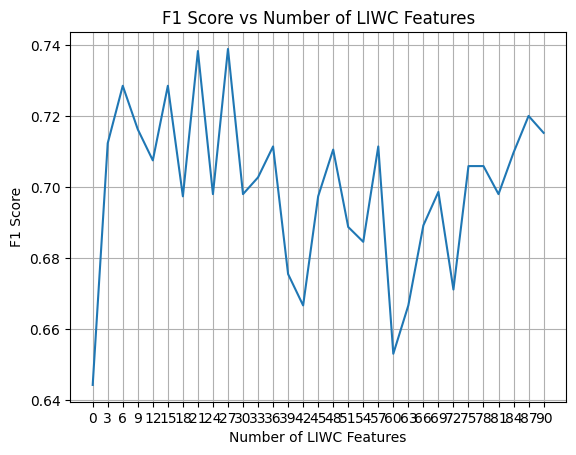

In [ ]:
# XGBoost
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

df_2 = df.copy()

k = range(0, len(effect_df), 3)  # Test every 3 features

best_k = 0
best_f1 = 0
f1_vals = []
best_xgb = None
best_feature_cols = None

for i in k:
    feature_cols = list(effect_df.head(i).index) + ["sentiment"]

    X = df_2[feature_cols]
    y = df_2["label"]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric="logloss",
        random_state=42
    )

    xgb.fit(X_train, y_train)

    val_preds = xgb.predict(X_val)
    val_probs = xgb.predict_proba(X_val)[:,1]

    f1_vals.append(f1_score(y_val, val_preds))

    if f1_score(y_val, val_preds) > best_f1:
        best_f1 = f1_score(y_val, val_preds)
        best_k = i
        best_xgb = xgb
        best_feature_cols = feature_cols

print(f"Best F1: {best_f1:.4f} with top {best_k} LIWC features")

plt.plot(k, f1_vals)
plt.xlabel("Number of LIWC Features")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Number of LIWC Features")
plt.xticks(k)
plt.grid()
plt.show()

We achieved the best F1 score using 27 most impactful features. Let's take a look at what these 27 features are.

In [110]:
importances = pd.Series(
    best_xgb.feature_importances_,
    index=best_feature_cols
).sort_values(ascending=False)

print(importances)

lex_liwc_negemo          0.083119
lex_liwc_death           0.068585
lex_liwc_i               0.059446
lex_liwc_anx             0.057363
sentiment                0.048531
lex_liwc_swear           0.048027
lex_liwc_anger           0.043049
lex_liwc_affect          0.040336
lex_liwc_bio             0.035986
lex_liwc_sad             0.033898
lex_liwc_Authentic       0.032510
lex_liwc_risk            0.032185
lex_liwc_conj            0.030155
lex_liwc_health          0.029855
lex_liwc_focuspresent    0.029717
lex_liwc_feel            0.028308
lex_liwc_WC              0.027576
lex_liwc_Dic             0.026776
lex_liwc_function        0.026525
lex_liwc_pronoun         0.026514
lex_liwc_auxverb         0.026129
lex_liwc_body            0.026027
lex_liwc_negate          0.026011
lex_liwc_time            0.024119
lex_liwc_Apostro         0.023860
lex_liwc_verb            0.023182
lex_liwc_ppron           0.021831
lex_liwc_adverb          0.020382
dtype: float32


### Model 3: DistilBert + LIWC

Let's combine our first 2 models to build a multilayer perceptron classifier.

In [123]:
from transformers import DistilBertTokenizerFast, DistilBertModel
import torch

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

bert_model.eval()

def get_bert_embeddings(texts, batch_size=16):
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        
        with torch.no_grad():
            outputs = bert_model(**inputs)
        
        cls_embeddings = outputs.last_hidden_state[:,0,:]
        embeddings.append(cls_embeddings)
    
    return torch.cat(embeddings, dim=0)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 792.53it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generate Embeddings and convert to Numpy.

In [124]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df_1['label'],
    random_state=42
)

X_train_bert = get_bert_embeddings(train_df["text"].tolist())
X_val_bert = get_bert_embeddings(val_df["text"].tolist())

y_train_bert = train_df["label"].values
y_val_bert = val_df["label"].values

X_train_bert = X_train_bert.numpy()
X_val_bert = X_val_bert.numpy()

Prepare and standardize LIWC Features.

Best F1: 0.7973856209150327
Best Features: ['lex_liwc_negemo', 'lex_liwc_i', 'lex_liwc_anx', 'lex_liwc_Authentic', 'lex_liwc_sad', 'lex_liwc_feel', 'lex_liwc_anger', 'lex_liwc_function', 'lex_liwc_swear', 'lex_liwc_conj', 'lex_liwc_Dic', 'lex_liwc_risk', 'lex_liwc_body', 'lex_liwc_negate', 'lex_liwc_ppron', 'lex_liwc_bio', 'lex_liwc_adverb', 'lex_liwc_Apostro', 'lex_liwc_pronoun', 'lex_liwc_health', 'lex_liwc_affect', 'lex_liwc_focuspresent', 'lex_liwc_WC', 'lex_liwc_auxverb', 'lex_liwc_verb', 'lex_liwc_time', 'lex_liwc_death', 'lex_liwc_QMark', 'lex_liwc_compare', 'lex_liwc_cause', 'lex_liwc_relativ', 'lex_liwc_certain', 'lex_liwc_SemiC', 'lex_liwc_male', 'lex_liwc_differ', 'lex_liwc_home', 'lex_liwc_adj', 'lex_liwc_Dash', 'lex_liwc_percept', 'lex_liwc_interrog', 'lex_liwc_WPS', 'lex_liwc_family', 'lex_liwc_cogproc', 'lex_liwc_sexual', 'lex_liwc_space', 'lex_liwc_informal', 'lex_liwc_ingest', 'lex_liwc_insight', 'lex_liwc_motion', 'lex_liwc_shehe', 'lex_liwc_Period', 'lex_liwc_ipron',

Text(0.5, 1.0, 'F1 Score vs Number of LIWC Features (Combined with BERT)')

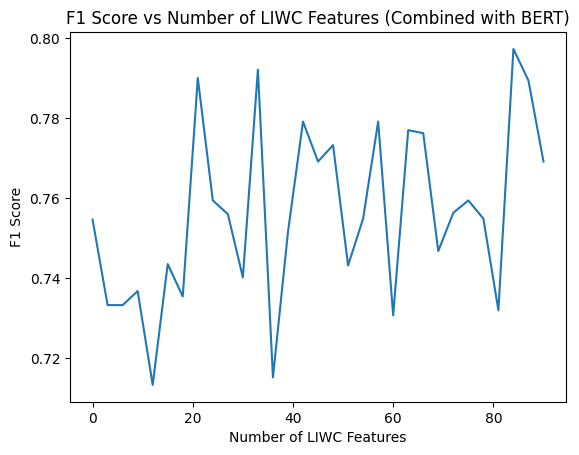

In [126]:
import numpy as np
from sklearn.neural_network import MLPClassifier

df_3 = df.copy()

best_f1 = 0
best_features = None
f1_vals = []
best_mlp = None


for i in range(0, len(effect_df), 3):  # Test every 3 features
    features_used = list(effect_df.head(i).index) + ["sentiment"]

    X_train_liwc = train_df[features_used].values
    X_val_liwc = val_df[features_used].values

    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_train_liwc = scaler.fit_transform(X_train_liwc)
    X_val_liwc = scaler.transform(X_val_liwc)

    X_train_combined = np.concatenate([X_train_bert, X_train_liwc], axis=1)
    X_val_combined = np.concatenate([X_val_bert, X_val_liwc], axis=1)

    mlp = MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=300,
        alpha=0.01,
        random_state=42
    )

    mlp.fit(X_train_combined, y_train)

    val_preds = mlp.predict(X_val_combined)

    f1_vals.append(f1_score(y_val, val_preds))

    if f1_score(y_val, val_preds) > best_f1:
        best_f1 = f1_score(y_val, val_preds)
        best_features = features_used
        best_mlp = mlp

print("Best F1:", best_f1)
print("Best Features:", best_features)
print("Best Number of LIWC Features:", len(best_features) - 1)  # Subtract 1 for sentiment

plt.plot(range(0, len(effect_df), 3), f1_vals)
plt.xlabel("Number of LIWC Features")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Number of LIWC Features (Combined with BERT)")

Train MLP.

| Model                | F1   |
| -------------------- | ---- |
| TF-IDF + LR          | 0.66 |
| BERT                 | 0.75 |
| LIWC + XGB           | 0.74 |
| Hybrid (BERT + LIWC) | 0.80 |

### 4. Additional Analysis

### 4a. Let's dive deeper into which subreddit is easier to predict.

In [117]:
df_4 = df.copy()

X_bert = get_bert_embeddings(df_4["text"].tolist()).numpy()
X_liwc = df_4[best_features].values
X_liwc = scaler.fit_transform(X_liwc)
X = np.concatenate([X_bert, X_liwc], axis=1)

model_chosen = best_mlp

df_4["pred"] = model_chosen.predict(X)
df_4["prob"] = model_chosen.predict_proba(X)[:, 1]

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

results = []

for sub in df_4["subreddit"].unique():
    subset = df_4[df_4["subreddit"] == sub]
    
    f1 = f1_score(subset["label"], subset["pred"])
    acc = accuracy_score(subset["label"], subset["pred"])
    prec = precision_score(subset["label"], subset["pred"])
    rec = recall_score(subset["label"], subset["pred"])
    
    results.append((sub, len(subset), f1, acc, prec, rec))

import pandas as pd
results_df = pd.DataFrame(
    results,
    columns=["subreddit", "n", "f1", "accuracy", "precision", "recall"]
)

results_df.sort_values("f1", ascending=False)

,subreddit,n,f1,accuracy,precision,recall
5,almosthomeless,19,1.000000,1.000000,1.000000,1.000000
1,anxiety,147,0.977011,0.972789,0.955056,1.000000
3,assistance,66,0.976744,0.984848,0.954545,1.000000
6,domesticviolence,72,0.968421,0.958333,0.958333,0.978723
2,ptsd,127,0.962963,0.952756,0.975000,0.951220
0,relationships,142,0.949153,0.957746,0.965517,0.933333
8,stress,14,0.947368,0.928571,1.000000,0.900000
7,survivorsofabuse,70,0.923077,0.928571,0.882353,0.967742
4,homeless,52,0.888889,0.923077,0.888889,0.888889
9,food_pantry,6,0.857143,0.833333,0.750000,1.000000


### 4b. Let's look up some cases where our model confidently predicts the wrong label.

In [ ]:
wrong = df_4[df_4["label"] != df_4["pred"]]

confident_wrong = wrong[
    (wrong["prob"] > 0.8) | 
    (wrong["prob"] < 0.2)
]

confident_wrong = confident_wrong.sort_values("prob", ascending=False)

for idx, row in confident_wrong.iterrows():
    print(f"Subreddit: {row['subreddit']}")
    print(f"True Label: {row['label']}, Predicted: {row['pred']}, Prob: {row['prob']:.4f}")
    print(f"Text: {row['text']}")
    print("-" * 80)


Subreddit: survivorsofabuse
True Label: 0, Predicted: 1, Prob: 1.0000
Text: But it took me months afterward to end it. I remember him screaming at me, calling me stupid, calling me a moody bitch when I got frustrated at him for screaming and insulting me, threatening to break up with me, holding his “love” for me over my head when I wasn’t doing things his way, getting drunk and high and cheating on me and then coercing me into helping him fake a piss test, and on and on and on.... And the whole time I knew he was being an abusive asshole and I *still stayed. * I had absolutely no reason not to leave him, and it was 100% in my power to end things between us. But I didn’t.
--------------------------------------------------------------------------------
Subreddit: relationships
True Label: 0, Predicted: 1, Prob: 1.0000
Text: and I giggled. He stomped towards me, mocked my laugh with an angry face and ripped the keys from my hands. He grabbed me by the top of my shirt and looked me in my 

### 4c. Comparing the influence of BERT and LIWC features

In [120]:
from sklearn.inspection import permutation_importance
import numpy as np

r = permutation_importance(
    model_chosen,
    X, 
    df_4["label"].values,
    scoring="f1",
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)
 
importances = r.importances_mean

bert_importance = np.sum(importances[:768])
liwc_importance = np.sum(importances[768:])

print("Total BERT importance:", bert_importance)
print("Total LIWC importance:", liwc_importance)

Total BERT importance: -0.12365235919569609
Total LIWC importance: 0.16918384098109723


Finding out the more important LIWC features.

In [121]:
liwc_cols = [col for col in df.columns if col.startswith("lex_liwc")]

liwc_importances = importances[768:]
sorted_idx = np.argsort(liwc_importances)[::-1]

for i in sorted_idx[:10]:
    print(liwc_cols[i], liwc_importances[i])

lex_liwc_Clout 0.009384369076965372
lex_liwc_pronoun 0.007201512298226831
lex_liwc_female 0.006903414336517172
lex_liwc_adj 0.006673719321694127
lex_liwc_adverb 0.006044501139351161
lex_liwc_negate 0.005917330760451628
lex_liwc_focusfuture 0.005788475170695878
lex_liwc_you 0.00528546295459949
lex_liwc_WC 0.005161779976525333
lex_liwc_i 0.004979374021737632
